In [1]:
import numpy as np
import gymnasium as gym
import torch
from torch import nn
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
def run_once(env: gym.Env, action_policy) -> int:
    """Run the environment once and return the number of episodes this ran for 

    Args:
        env (gym.Env): The gym environment
        action_policy (Callable): A callable that takes in an observation, last reward, episode number, and termination status. Then it spits out the action to take

    Returns:
        int: the number of episodes this ran for
        bool: terminated
        bool: truncated
    """
    observation, info = env.reset()
    terminated = False
    truncated = False
    episodes = 0
    reward = 0
    action = action_policy(observation, reward, episodes, False)
    while not terminated and not truncated:
        # action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        episodes += 1
        if terminated: reward = 0.0
        action = action_policy(observation, reward, episodes, terminated)
    return episodes, terminated, truncated
def run_n_times(env: gym.Env, action_policy, n, after_run_callback=lambda episode_len: None, avg_size=10, progressbar:bool = False) -> list[int]:
    episode_lengths = []
    t = trange(n) if progressbar else range(n)
    for _ in t:
        try:
            episode_lengths.append(run_once(env, action_policy)[0])
            after_run_callback(episode_lengths[-1])
            try:
                lens = episode_lengths[-avg_size]
            except IndexError:
                lens = episode_lengths
            if progressbar:
                t.set_description(f"Average episode len: {np.mean(lens)}")
        except KeyboardInterrupt:
            break
    return episode_lengths
    # return [run_once(env, action_policy)[0] for _ in (trange(n) if progressbar else range(n))]
    


In [3]:
class DQN(nn.Module):
    def __init__(self, observation_size, actionspace_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.stack = nn.Sequential(
            nn.Linear(observation_size, 128),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, actionspace_size),
        )
    def forward(self, x):
        return self.stack(x)

In [4]:
class DQN2(DQN):
    """This is a DQN with its own optimizer across multiple actions

    Args:
        DQN (_type_): _description_
    """
    def __init__(self, observation_size, actionspace_size, lr=1e-3, epsilon=0, epsilon_decay=1, min_epsilon=0.0001, gamma=0.9, batch_size=32, *args, **kwargs) -> None:
        super().__init__(observation_size, actionspace_size, *args, **kwargs)
        self.optimizer = torch.optim.AdamW(self.parameters(), lr)
        self.max_epsilon = epsilon
        self.epsilon = self.max_epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.loss = torch.tensor(0, requires_grad=True, dtype=torch.float32)
        self.batch_size = batch_size
        self.lossfn = lambda a, b: (a-b)**2
        self.action_space = torch.distributions.Categorical(torch.ones(actionspace_size))
        self.thoughts = 0
        
        # These histories are just to explore and visualzie
        self.loss_history = []
        self.prediction_history = []
        self.reward_history = []
        self.updates = 0

    
    def act(self, observation, previous_reward, episode, terminated):
        preds = self(torch.from_numpy(observation))
        self.prediction_history.append(preds.tolist())

        epsilon = self.epsilon if self.training else 0
        action = self.action_space.sample().item() if torch.rand(1).item() < epsilon else preds.argmax().item()
        if self.training:
            self.think(observation, action, preds, previous_reward, episode, terminated)
        return action

    def think(self, observation, action, preds, previous_reward, episode, terminated):
        if episode == 0:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.min_epsilon:
                self.epsilon = self.max_epsilon
            self.cr1 = preds[action]
            self.last_action = action
            return

        self.cr2 = preds.max() # Q-Learning
        # self.cr2 = preds[action] # SARSA Learning
        predicted_reward = self.cr1 - self.cr2*self.gamma
        self.reward_history.append((predicted_reward.item(), previous_reward))
        loss = self.lossfn(predicted_reward, previous_reward)
        if terminated: 
            loss += (preds**2).sum() # All cumilative rewards should be 0 from a state that is terminated
        self.loss = self.loss + loss
        self.thoughts += 1
        self.loss_history.append(loss.detach().item())

        
        if self.thoughts >= self.batch_size:
            self.think_harder()
            self.thoughts = 0
        self.cr1 = self(torch.from_numpy(observation))[action]
        
    
    
    def think_harder(self):
        loss = self.loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.parameters(), 100)
        self.optimizer.step()
        self.loss = torch.tensor(0, requires_grad=True, dtype=torch.float32)
        self.updates += 1

In [5]:
def sample(a, n):
    a = np.array(a)
    idx = np.random.choice(np.arange(len(a)), n, replace=False)
    idx.sort(0) if len(idx.shape) == 1 else None
    return a[idx].tolist()
def sample_if(a, n):
    if len(a) > n:
        return sample(a, n)
    else: 
        return a
def plot_model(model, episodes, sample_size=None):
    # sample_size = 1000
    plt.subplots(2, 2, figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.title("episode durations")
    window_size = 1
    eps = np.convolve(episodes, [1/window_size]*window_size)
    eps = sample_if(eps, sample_size) if sample_size is not None else eps
    plt.scatter(np.arange(len(eps)), eps, s=0.1)
    window_size = 10
    plt.subplot(2, 2, 2)
    lh = np.convolve(model.loss_history, [1/window_size]*window_size)
    lh = sample_if(lh, sample_size) if sample_size is not None else lh
    plt.plot(lh, ',')
    plt.title("loss over consecutive actions")
    plt.subplot(2, 2, 3)
    ph = sample_if(model.prediction_history, sample_size) if sample_size is not None else model.prediction_history
    plt.scatter(*zip(*ph), s=0.1, c=(1+np.arange(len(ph)))**0.7)
    plt.title("Cumilative reward prediction for consecutive actions")
    plt.subplot(2,2,4)
    rewards = np.array(sample_if(model.reward_history, sample_size) if sample_size is not None else model.reward_history)
    rewards[:, 1] += np.random.randn(rewards.shape[0])*0.005
    plt.scatter(*rewards.T, s=0.1, c=(1+np.arange(rewards.shape[0]))**0.7)
    plt.axvline(0, linestyle='--')
    plt.axvline(1, linestyle='--')
    plt.title("reward predictions over consecitve predictions")
    plt.suptitle(f"{model.updates} updates")

In [6]:
env = gym.make("CartPole-v1")
model = DQN2(env.observation_space.shape[0], 2, epsilon=1, epsilon_decay=0.999, min_epsilon=0, lr=0.001)
episodes = []

start epsilon: 1


Average episode len: 239.0: 100%|██████████| 1300/1300 [01:13<00:00, 17.60it/s]          


end epsilon: 0.27235458681947705
1300 episodes total


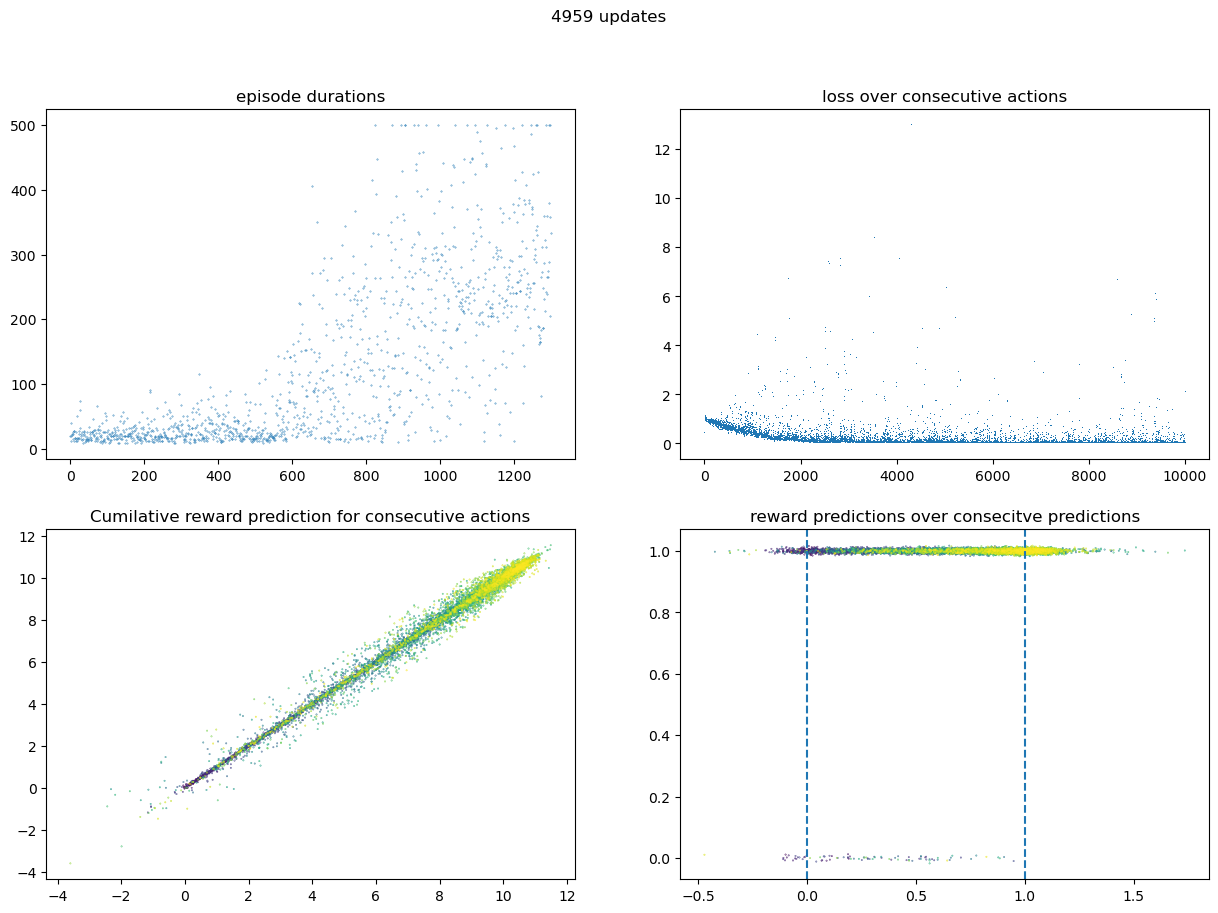

In [7]:
print(f'start epsilon: {model.epsilon}')
episodes += run_n_times(env, model.act, 1300, progressbar=True)
print(f'end epsilon: {model.epsilon}')
print(f'{len(episodes)} episodes total')
plot_model(model, episodes, 10_000)

In [8]:
vizenv = gym.make("CartPole-v1", render_mode='human')

In [13]:
model.eval()
print(f"{run_once(vizenv, model.act)} episodes, epsilon: {model.epsilon}")
model.train()
None

(500, False, True) episodes, epsilon: 0.27235458681947705


In [14]:
vizenv.close()